# Overwatch Ult Charge

In [23]:
import collections
import os.path
import random

import cv2
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import tqdm

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

MNIST_MODEL_LOC = 'mnist.h5'

Bbox = collections.namedtuple('Bbox', ['x','y','w','h'])

def crop_region(full_image, bbox):
    x, y, w, h = bbox
    return full_image[y:y+h, x:x+w]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Display a random Overwatch frame

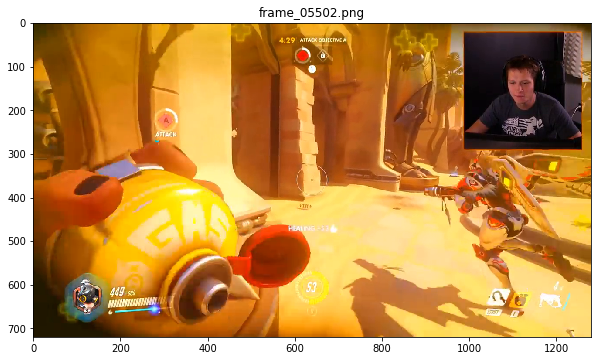

In [4]:
dirname = '/Users/ctang/Documents/overwatch_object_detection/overwatch_part1_frames/smaller_dataset'

# Uncomment if you want a single image
# random.seed(231)

files = os.listdir(dirname)
imgfile = random.choice(files)
image = mpimg.imread(os.path.join(dirname, imgfile))

plt.imshow(image)
plt.title(imgfile)
plt.show()

# Display region containing Ult Charge

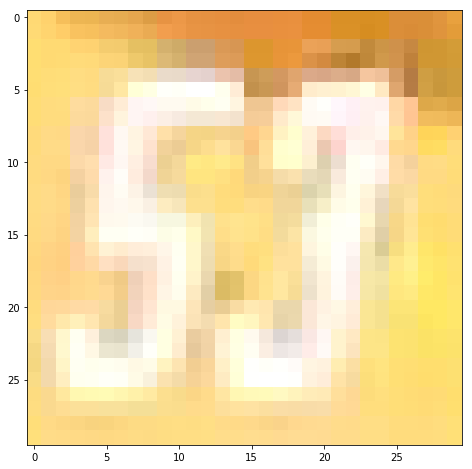

In [5]:
imgfile = 'frame_05514.png'
image = mpimg.imread(os.path.join(dirname, imgfile))
ult_bbox = Bbox(x=625, w=30, y=590, h=30)
plt.imshow(crop_region(image, ult_bbox))
plt.show()

# Train an MNIST model

In [8]:
'''Trains a simple convnet on the MNIST dataset.
Gets to 99.25% test accuracy after 12 epochs
(there is still a lot of margin for parameter tuning).
16 seconds per epoch on a GRID K520 GPU.
'''

from __future__ import print_function
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
from keras.models import load_model

batch_size = 128
num_classes = 10
epochs = 12

# input image dimensions
img_rows, img_cols = 28, 28

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

if os.path.exists(MNIST_MODEL_LOC):
    model = load_model(MNIST_MODEL_LOC)
else:
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3),
                     activation='relu',
                     input_shape=input_shape))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.Adadelta(),
                  metrics=['accuracy'])

    model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              verbose=1,
              validation_data=(x_test, y_test))

score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples
Test loss: 0.0297505717966
Test accuracy: 0.9897


In [74]:
model.save('mnist.h5')
model.save_weights('mnist.weights.h5')

In [52]:
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()

(28, 28)


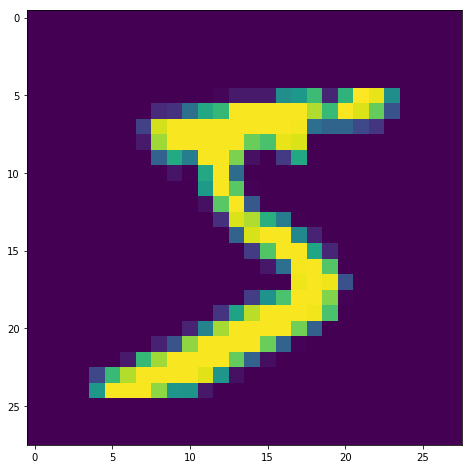

In [75]:
x = X_train[0]
print(x.shape)
plt.imshow(x)

# Display tens and ones digits

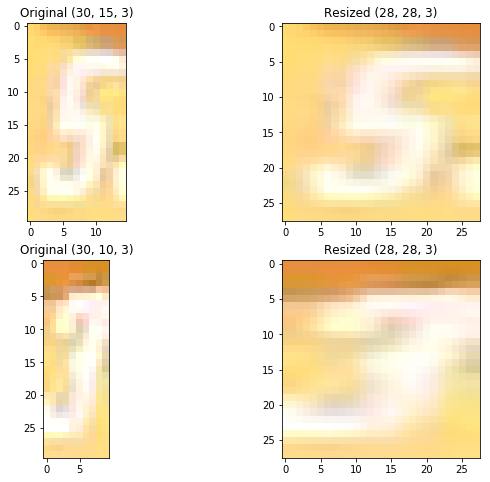

In [24]:
tens = crop_region(image, Bbox(x=625, y=590, w=15, h=30))
plt.subplot(2, 2, 1)
plt.imshow(tens)
plt.title("Original %s" % str(tens.shape))

tens_resized = cv2.resize(tens, (28, 28))
plt.subplot(2, 2, 2)
plt.imshow(tens_resized)
plt.title("Resized %s" % str(tens_resized.shape))

ones = crop_region(image, Bbox(x=640, y=590, w=10, h=30))
plt.subplot(2, 2, 3)
plt.imshow(ones)
plt.title("Original %s" % str(ones.shape))

ones_resized = cv2.resize(ones, (28, 28))
plt.subplot(2, 2, 4)
plt.imshow(ones_resized)
plt.title("Resized %s" % str(ones_resized.shape))

plt.show()

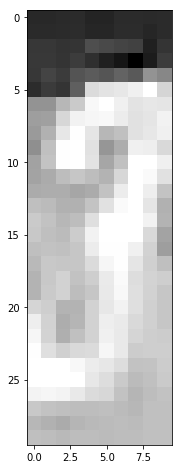

In [228]:
plt.imshow(ones[:,:,1], cmap='gray')

In [17]:
N, H, W, C = 1, 28, 28, 1
region = ones_resized[:,:,1].reshape(N, H, W, C)
result = model.predict(region)
print("actual=%d, predicted=%d" % (3, np.argmax(result)))

actual=3, predicted=3


# Prepare an evaluation dataset

In [18]:
dirname = '/Users/ctang/Documents/overwatch_object_detection/overwatch_part1_frames/smaller_dataset'

# Ult charge at 53%
start = 5474
end = 5541
fifty_three = [os.path.join(dirname, "frame_0%d.png" % i) for i in range(start, end+1)]

# Ult charge at 54%
start = 5542
end = 5574
fifty_four = [os.path.join(dirname, "frame_0%d.png" % i) for i in range(start, end+1)]

In [27]:
dataset_dirname = '/Users/ctang/dev/datasets/overwatch_digits'
prefix_5 = '5_'
prefix_4 = '4_'
prefix_3 = '3_'

tens_bbox = Bbox(x=625, y=590, w=15, h=30)
ones_bbox = Bbox(x=640, y=590, w=10, h=30)

x_valid = []
y_valid = []

for i, imgfile in tqdm.tqdm(enumerate(fifty_three)):
    five = crop_region(mpimg.imread(imgfile), tens_bbox)
    three = crop_region(mpimg.imread(imgfile), ones_bbox)
    
    x_valid.append(five)
    x_valid.append(three)
    y_valid.append(5)
    y_valid.append(3)
print('Done producing 5 and 3 images.')

for i, imgfile in tqdm.tqdm(enumerate(fifty_four)):
    five = crop_region(mpimg.imread(imgfile), tens_bbox)
    four = crop_region(mpimg.imread(imgfile), ones_bbox)
    
    x_valid.append(five)
    x_valid.append(four)
    y_valid.append(5)
    y_valid.append(4)
print('Done producing 5 and 4 images.')

68it [00:06, 12.39it/s]
0it [00:00, ?it/s]

Done producing 5 and 3 images.


33it [00:02, 11.90it/s]

Done producing 5 and 4 images.


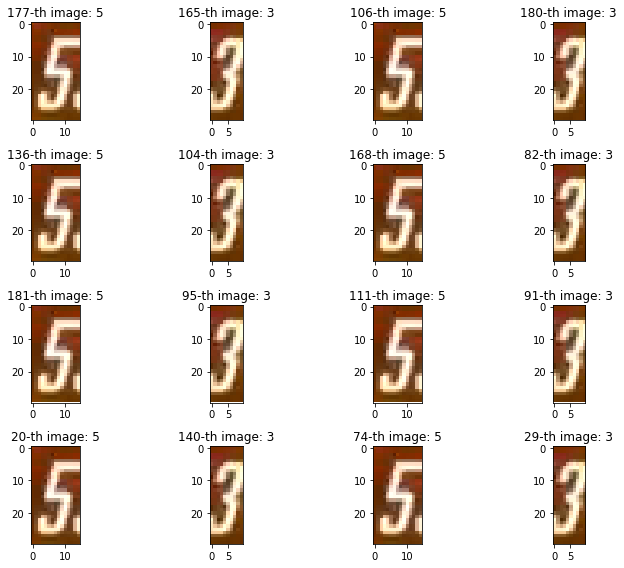

In [39]:
# Display a grid of labels + regions
for i, region in enumerate(random.sample(range(len(x_valid)), 16)):
    plt.subplot(4, 4, i+1)
    plt.imshow(x_valid[i])
    plt.title("%d-th image: %d" % (region, y_valid[i]))

plt.tight_layout()
plt.show()

In [159]:
dataset_dirname = '/Users/ctang/dev/datasets/overwatch_digits'
prefix_5 = '5_'
prefix_4 = '4_'
prefix_3 = '3_'

tens_bbox = Bbox(x=625, y=590, w=15, h=30)
ones_bbox = Bbox(x=640, y=590, w=10, h=30)

i = 0
for imgfile in tqdm.tqdm(fifty_three):
    five = region(mpimg.imread(imgfile), tens_bbox)
    three = region(mpimg.imread(imgfile), ones_bbox)
    five_filename = "%s%d.png" % (prefix_5, i)
    three_filename = "%s%d.png" % (prefix_3, i)
    mpimg.imsave(fname=os.path.join(dataset_dirname, five_filename), arr=five)
    mpimg.imsave(fname=os.path.join(dataset_dirname, three_filename), arr=three)
    i += 1
print('Done producing 5 and 3 images.')

for imgfile in tqdm.tqdm(fifty_four):
    five = region(mpimg.imread(imgfile), tens_bbox)
    four = region(mpimg.imread(imgfile), ones_bbox)
    five_filename = "%s%d.png" % (prefix_5, i)
    four_filename = "%s%d.png" % (prefix_4, i)
    mpimg.imsave(fname=os.path.join(dataset_dirname, five_filename), arr=five)
    mpimg.imsave(fname=os.path.join(dataset_dirname, four_filename), arr=four)
    i += 1
print('Done producing 5 and 4 images.')

  6%|▌         | 2/33 [00:00<00:02, 12.80it/s]

Done producing 5 and 3 images.


100%|██████████| 33/33 [00:02<00:00, 13.11it/s]

Done producing 5 and 4 images.


# Preparing image regions as input into a CNN

Convert the image regions from HxWx4 to 28x28x1.

In [68]:
from skimage import color

x_valid_input = []
y_valid_input = np.array(y_valid)

for x, y in zip(x_valid, y_valid):
    warped = cv2.resize(x, (28, 28), interpolation=cv2.INTER_LINEAR)
    gray = color.rgb2gray(warped)
#     gray = gray.reshape(28, 28, 1)
    x_valid_input.append(gray)

x_valid_input = np.array(x_valid_input)
print("Done")

Done


In [214]:
x_valid = []
y_valid = []

for filename in os.listdir(dataset_dirname):
    _, ext = os.path.splitext(filename)
    if ext not in ['.png']:
        continue

    img = mpimg.imread(os.path.join(dataset_dirname, filename))
    img = cv2.resize(img, (28, 28))
    x_valid.append(img[:,:,2].reshape(28, 28, 1)) # 2 is the best!
    if filename[0] == '5':
        y_valid.append(5)
    elif filename[0] == '4':
        y_valid.append(4)
    else:
        y_valid.append(3)

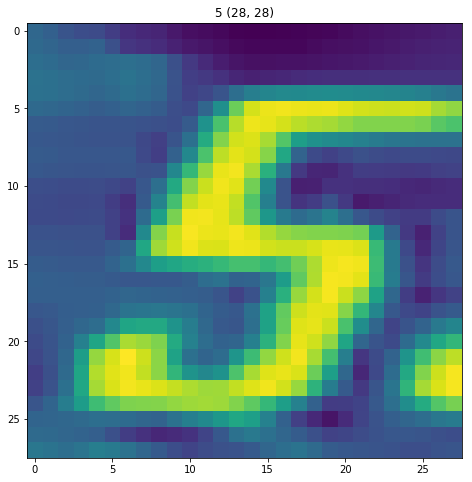

In [71]:
idx = random.randint(0, len(x_valid_input))
plt.imshow(x_valid_input[idx])
plt.title("%d %s" % (y_valid_input[idx], x_valid_input[idx].shape))
plt.show()

In [72]:
# plt.imshow needs either HxWx3 or HxW if C == 1
# so convert image from HxW to HxWx1 when ready for input into CNN
x_val = x_valid_input.reshape(len(x_valid_input), 28, 28, 1)
y_val = y_valid_input
y_val = keras.utils.to_categorical(y_val, num_classes)
score = model.evaluate(x_val, y_val, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 1.48412906651
Test accuracy: 0.584158415842


# Data Augmentation
## Synthetic Data
Since we're simply classifying the ult digits in Overwatch, we can generate more of them.